In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [12]:
import tensorflow as tf
import numpy as np

In [13]:
IMG_SIZE = (224, 224)  # Change based on model (e.g., ResNet expects 224x224)
BATCH_SIZE = 32

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    label_mode='categorical',  # 'int' or 'categorical'
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 557 files belonging to 2 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/test',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 140 files belonging to 2 classes.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # Flip images left-right
    layers.RandomRotation(0.1),             # Rotate up to 10%
    layers.RandomZoom(0.1),                 # Zoom in/out
    layers.RandomContrast(0.1),             # Contrast changes
])


In [31]:
from tensorflow.keras import layers, models

model = models.Sequential([
    data_augmentation,  # Apply data augmentation
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: cat, dog
])

f:\ml projects\neural netwoks\cat and dog\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Because we used label_mode='categorical'
    metrics=['accuracy']
)


In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=5,          
    restore_best_weights=True  
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5
)


In [34]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop,lr_scheduler]  # Adjust epochs as needed
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.4794 - loss: 2.2762 - val_accuracy: 0.5000 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.5224 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.5314 - loss: 0.6945 - val_accuracy: 0.4571 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.5260 - loss: 0.6907 - val_accuracy: 0.4286 - val_loss: 0.6980 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.5476 - loss: 0.6816 - val_accuracy: 0.5714 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.5907 - loss: 0.6739 - val_accuracy: 0.6000 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.6068 - loss: 0.6837 - 

In [35]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc*100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6571 - loss: 0.6770
Test accuracy: 65.71%


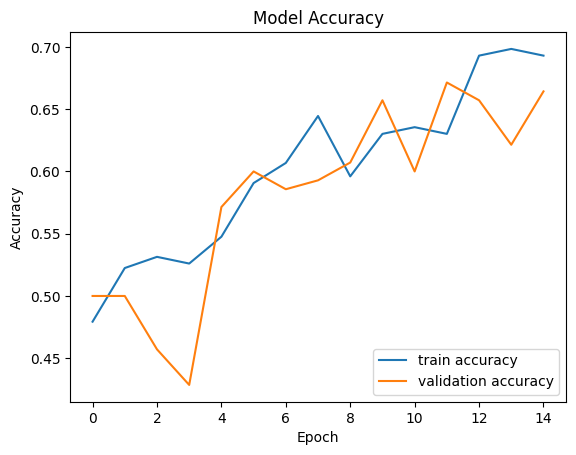

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

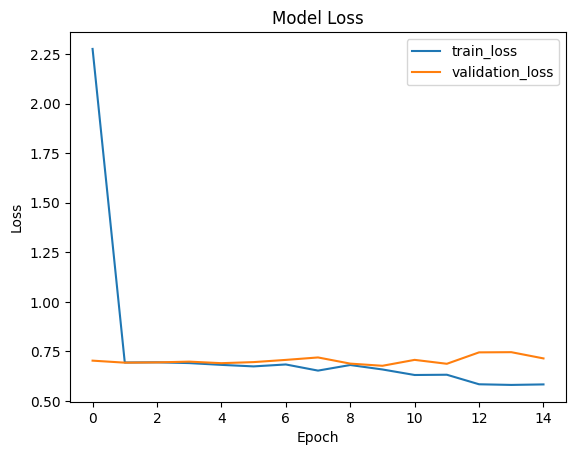

In [40]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [49]:
model.save('cat_dog_classifier_s.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


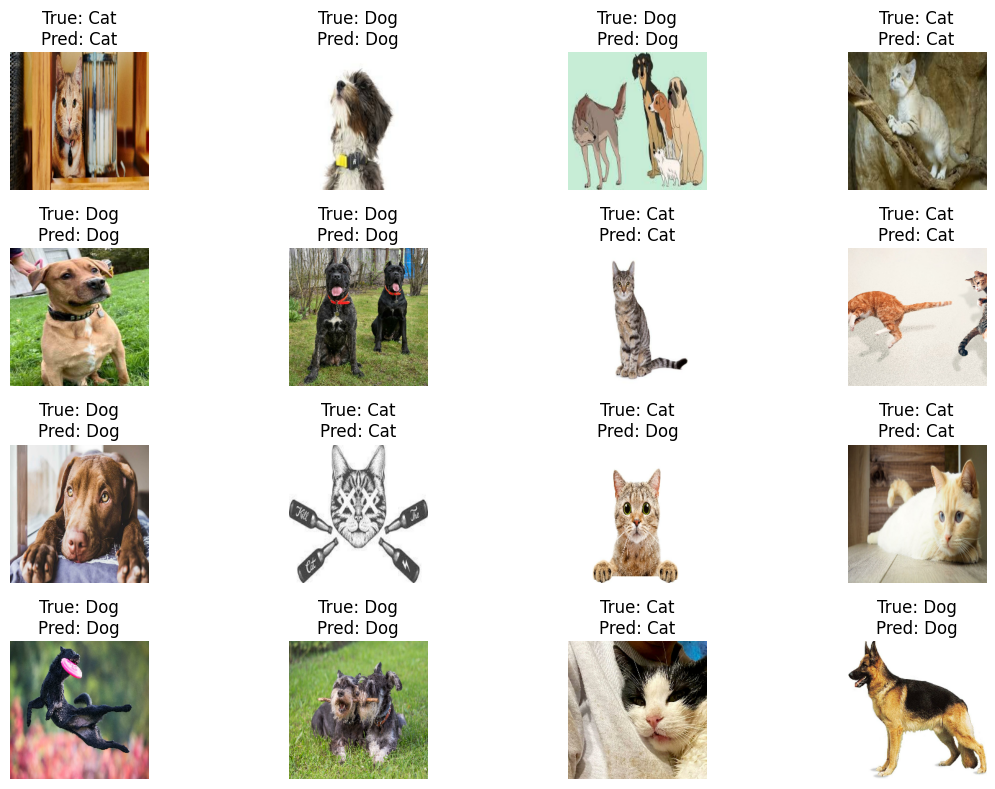

In [43]:
import numpy as np

# Get a batch of test images
class_names = ['Cat', 'Dog']
test_images, test_labels = next(iter(test_ds.unbatch().batch(16)))

pred_probs = model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    true_label_idx = np.argmax(test_labels[i])
    plt.title(f"True: {class_names[true_label_idx]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


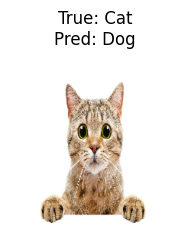

In [45]:
# Convert one-hot test_labels to class indices
true_labels = np.argmax(test_labels, axis=1)
wrong = np.where(pred_labels != true_labels)[0]

plt.figure(figsize=(12, 8))
for i in range(min(16, len(wrong))):
    idx = wrong[i]
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[idx].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

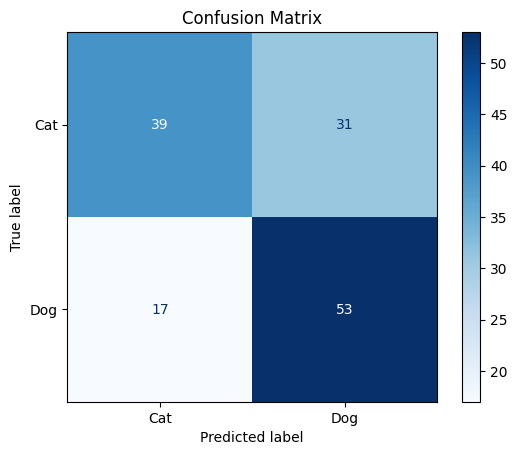

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for img, label in test_ds.unbatch():
    y_true.append(label.numpy())
    pred = np.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=1)[0]
    y_pred.append(pred)

# Convert one-hot encoded y_true to class indices
y_true_indices = [np.argmax(label) for label in y_true]

cm = confusion_matrix(y_true_indices, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
